# Лабораторная работа №1: Поэлементные преобразования изображений
## Вариант: №7
## Выполнил: Соколов Роман
## Группа: 6131-010402D

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import product
from tqdm.notebook import tqdm
from IPython.display import clear_output
from warnings import filterwarnings
from itertools import repeat

import cv2

In [2]:
PROBABILITY = 0.12

KERNEL = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])

FIR_KERNEL = (1/5) * np.array([
    [1, 0, 1], 
    [0, 1, 0], 
    [1, 0, 1]
])

In [3]:
def show_image(img):
    plt.figure(figsize=(10, 10))
    plt.imshow(img)

In [4]:
image = 'image/cat1.jpg'
img = cv2.imread(image)

In [5]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

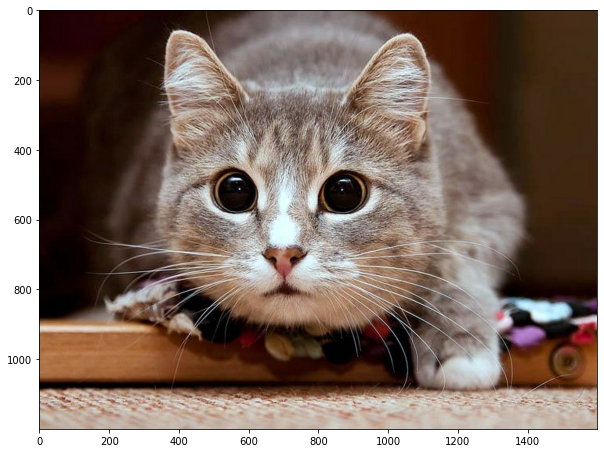

In [6]:
show_image(img)

# 2. Наложение шумов

In [7]:
def add_noise(image, probability):
    
    image_rows, image_cols, image_channels = image.shape
    output_image = np.copy(image)
    pixels = []

    for pixel in list(product(range(image_rows), range(image_cols))):
        if np.random.random() <= probability:
            pixels.append(pixel)

    for pixel in tqdm(pixels):
        for image_channel in range(image_channels):
            if output_image[pixel[0], pixel[1]][image_channel] + 50 > 255:
                output_image[pixel[0], pixel[1]][image_channel] = 255
            else:
                output_image[pixel[0], pixel[1]][image_channel] += 50

    clear_output()            
    return output_image

In [8]:
img2 = add_noise(img, PROBABILITY)

Исходное изображение


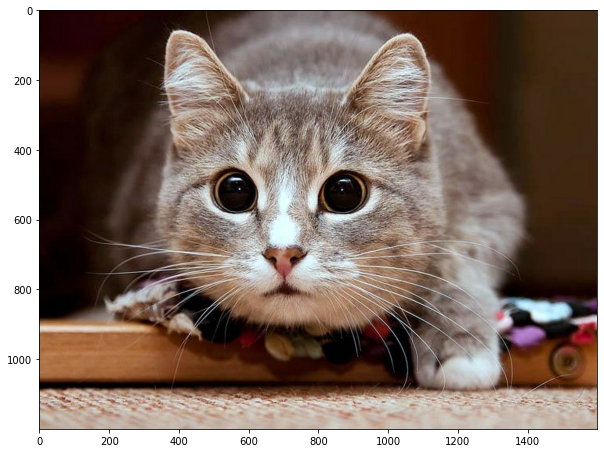

In [9]:
print('Исходное изображение')
show_image(img)

Изображение с шумом


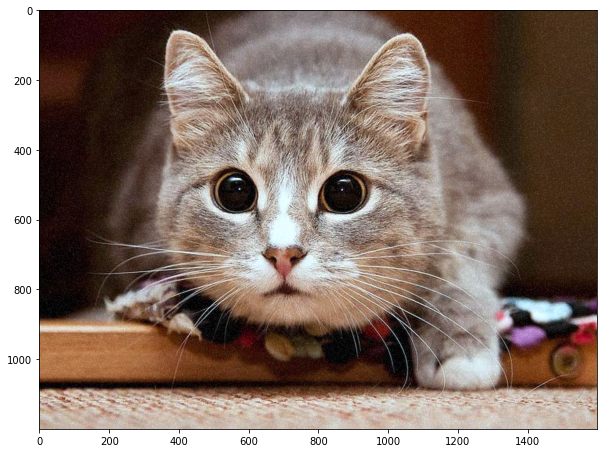

In [10]:
print('Изображение с шумом')
show_image(img2)

# 3. Функция реализации ранговой фильтрации

In [11]:
def rank_filtering(image, kernel, rank):

    image_rows, image_cols, image_channels = image.shape
    kernel_cols, kernel_rows = kernel.shape[0] // 2, kernel.shape[1] // 2
    output_image = np.zeros((image_rows, image_cols, image_channels), dtype=np.uint8)

    for i in tqdm(range(kernel_rows, image_rows - kernel_rows)):
        for j in range(kernel_cols, image_cols - kernel_cols):
            current_window = image[i - kernel_rows: i + kernel_rows + 1, j - kernel_cols: j + kernel_cols + 1]
            output_image[i, j] = get_value(current_window, kernel, rank)

    clear_output()
    return output_image


def get_value(image, kernel, rank):

    image_rows, image_cols, image_channels = image.shape
    output_image = np.zeros((image_channels, ))

    for image_channel in range(image_channels):
        vals = []
        for i in range(image_rows):
            for j in range(image_cols):
                for _ in range(kernel[i, j]):
                    vals.append(image[i, j, image_channel])

        output_image[image_channel] = np.sort(vals, axis=0)[rank]

    return output_image

Исходное изображение:


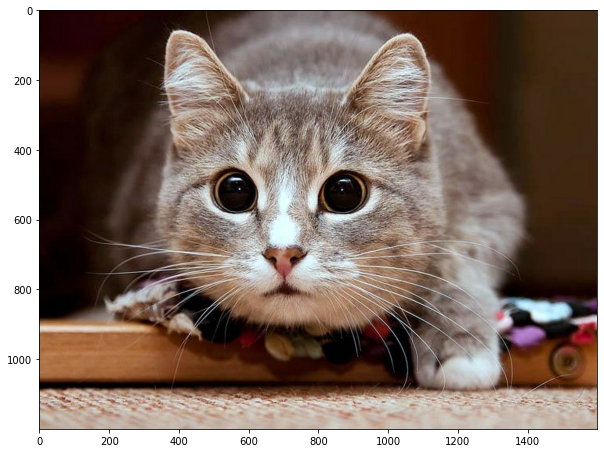

In [12]:
print("Исходное изображение:")
show_image(img)

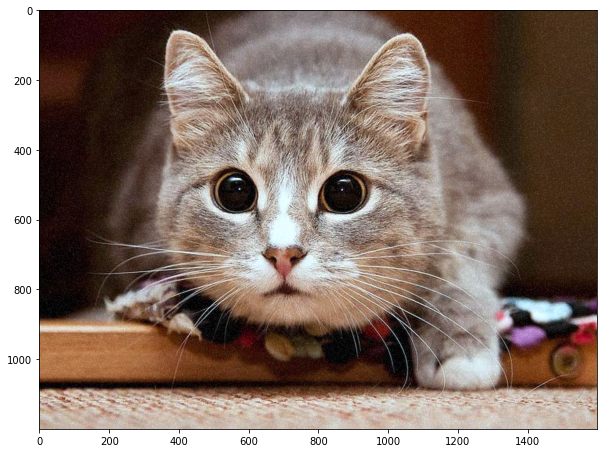

In [13]:
show_image(img2)

In [14]:
img3 = rank_filtering(img2, KERNEL, 1)

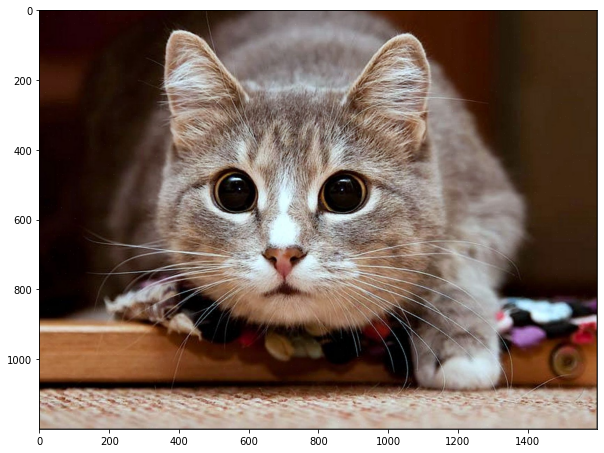

In [15]:
show_image(img3)

# 4. Отфильтровать зашумленное изображение со всеми возможными рангами (кол-во рангов зависит от окна по вариантам). Подсчитать СКО для результата фильтрации с каждым рангом.

In [16]:
def calculating_mse(image, image_noise):

    return np.sum((image - image_noise)**2)/(image.shape[0] * image.shape[1] * image.shape[2])

In [17]:
results = []

for rank in tqdm(range(1, np.sum(KERNEL.flatten()))):
    mse = calculating_mse(img, rank_filtering(img2, KERNEL, rank))
    results.append((rank, mse))
    clear_output()
    print(f"Rank: {rank}, MSE: {mse}")

sorted_results = sorted(results, key=lambda x: x[1])

Rank: 4, MSE: 86.06387204861112


In [18]:
sorted_results

[(2, 9.637930555555556),
 (1, 12.01156701388889),
 (3, 34.29444982638889),
 (4, 86.06387204861112)]

Исходное изображение:
MSE: 0.0


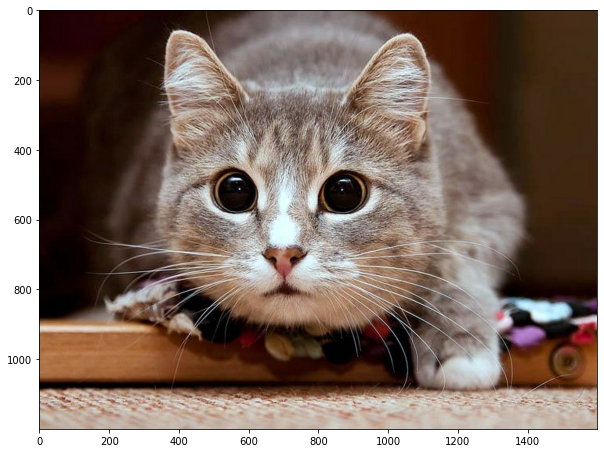

In [19]:
print("Исходное изображение:")
print(f"MSE: {calculating_mse(img, img)}")
show_image(img.astype('uint8'))

Зашумленное изображение:
MSE: 23.126669097222223


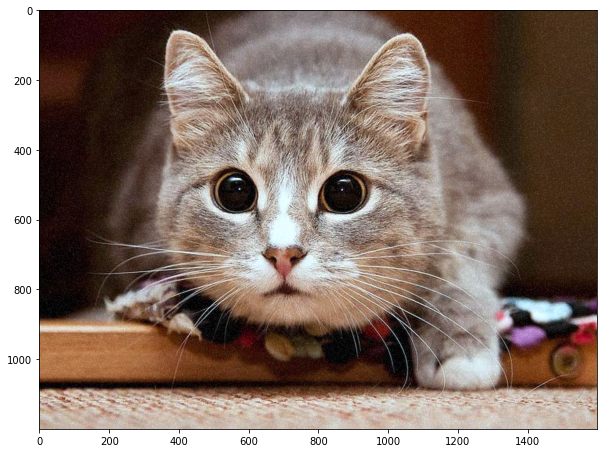

In [20]:
print("Зашумленное изображение:")
print(f"MSE: {calculating_mse(img, img2)}")
show_image(img2)

Rank: 1
MSE first rank: 12.01156701388889


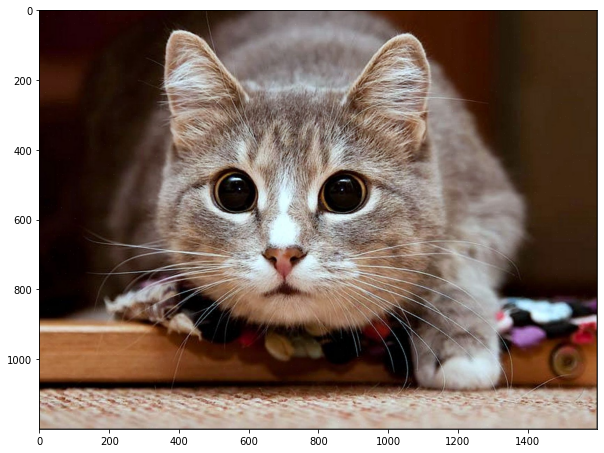

In [21]:
first_rank_image = rank_filtering(img2, KERNEL, 1)
print(f"Rank: {1}")
print(f"MSE first rank: {calculating_mse(img, first_rank_image)}")
show_image(first_rank_image)

Rank: 4
MSE last rank: 86.06387204861112


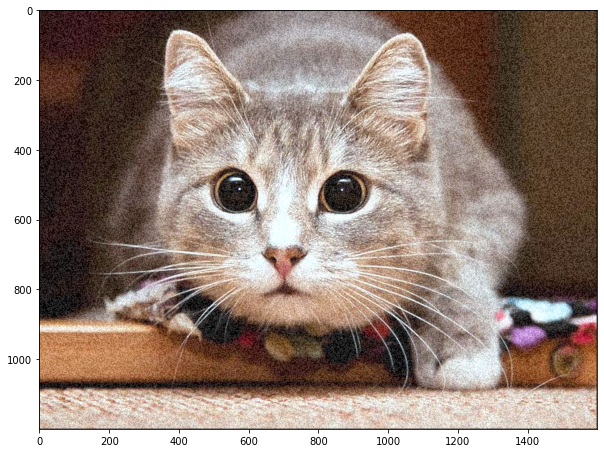

In [22]:
last_rank_image = rank_filtering(img2, KERNEL, 4)
print(f"Rank: {4}")
print(f"MSE last rank: {calculating_mse(img, last_rank_image)}")
show_image(last_rank_image)

Best rank: 2
MSE best rank: 9.637930555555556


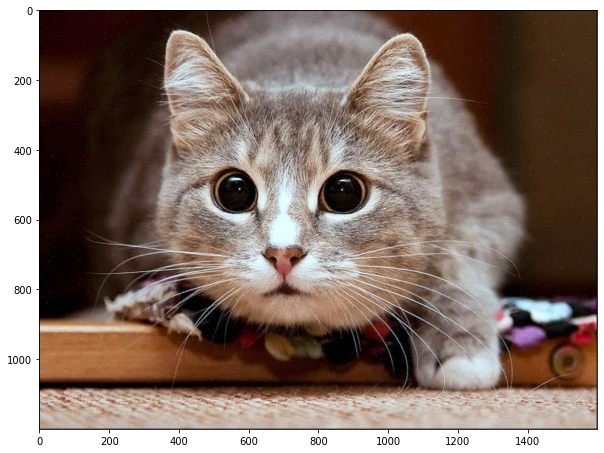

In [23]:
best_filtering_image = rank_filtering(img2, KERNEL, sorted_results[0][0])
print(f"Best rank: {sorted_results[0][0]}")
print(f"MSE best rank: {calculating_mse(img, best_filtering_image)}")
show_image(best_filtering_image)

# 5. Написать функцию реализации свертки

In [24]:
def convolution(image, kernel):

    __kernel = np.flipud(np.fliplr(kernel))
    image_rows, image_cols, image_channels = image.shape
    kernel_rows, kernel_cols = kernel.shape
    output_image = np.zeros_like(image)
    
    if kernel_rows % 2 == 0:
        output_image_rows = image_rows + (kernel_rows // 2)
        copy_rows = (0, image_rows)
    else:
        output_image_rows = image_rows + 2 * (kernel_rows // 2)
        copy_rows = (kernel_rows // 2, output_image_rows - (kernel_rows // 2))

    if kernel_cols % 2 == 0:
        output_image_cols = image_cols + (kernel_cols // 2)
        copy_cols = (0, image_cols)
    else:
        output_image_cols = image_cols + 2 * (kernel_cols // 2)
        copy_cols = (kernel_cols // 2, output_image_cols - (kernel_cols // 2))
    
    img = np.zeros((output_image_rows, output_image_cols, image_channels))
    img[copy_rows[0]: copy_rows[1], copy_rows[0]: copy_cols[1], :] = image

    for i, j, k in tqdm(np.ndindex((image_rows, image_cols, image_channels))):
        output_image[i, j, k] = np.sum(__kernel * img[i: i + kernel_rows, j: j + kernel_cols, k])

    clear_output()
    return output_image

#  6. Отфильтровать изображение КИХ фильтром с ядром заданным по вариантам. Подсчитать СКО. Сравнить с результатами пункта 4.

Исходное изображение:
MSE: 0.0


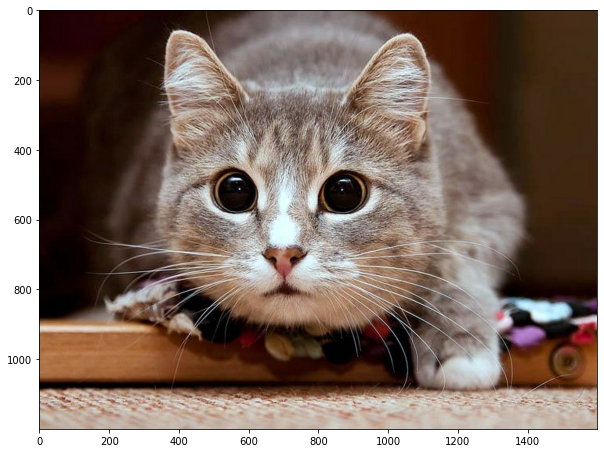

In [25]:
print("Исходное изображение:")
print(f"MSE: {calculating_mse(img, img)}")
show_image(img)

Зашумленное изображение:
MSE: 23.126669097222223


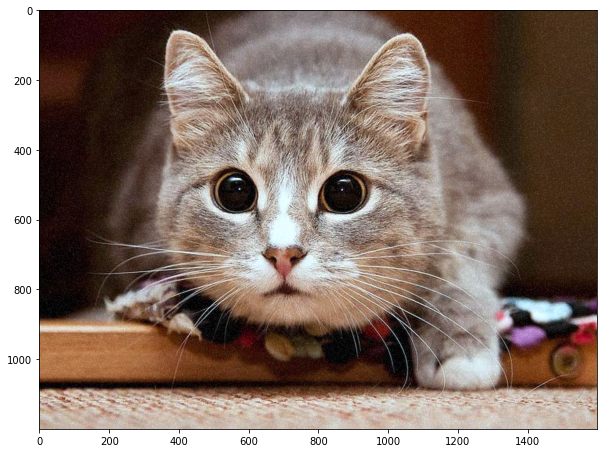

In [26]:
print("Зашумленное изображение:")
print(f"MSE: {calculating_mse(img, img2)}")
show_image(img2)

Изображение после КИХ-фильтра
FIR:
[[0.2 0.  0.2]
 [0.  0.2 0. ]
 [0.2 0.  0.2]]
MSE: 53.63691059027778


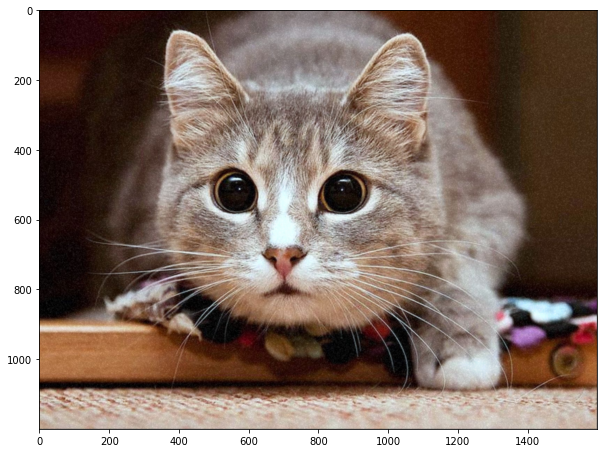

In [27]:
image_fir_filter = convolution(img2, FIR_KERNEL)
print("Изображение после КИХ-фильтра")
print(f"FIR:\n{FIR_KERNEL}")
print(f"MSE: {calculating_mse(img, image_fir_filter)}")
show_image(image_fir_filter)

# ИТОГ
## Ранговая фильтрация 2 ранга справилась с фильтрацией лучше чем КИХ-фильтр (1/5) * [1, 0, 1], [0, 1, 0], [1, 0, 1]